# Introducción

Este *notebook* incluye:
- Pequeños ejemplos de uso de *pandas*.
- Un *DataSet* (de *PyTorch*) que almacena información de los archivos de audio con los cantos de las aves. Este *DataSet*, al solicitársele el i-ésimo *item*, devuelve un cacho del i-ésimo audio, un cacho de un j-ésimo audio, y un 0 o 1 si `i != j` o `i == j` respectivamente.
- Un *DataLoader* (de *PyTorch*) que envuelve al *DataSet* previamente descrito.
- 

### Importaciones

Importación de las bibliotecas a utilizar, y una pequeña descripción de cada una.

In [1]:
# pandas is an open source data analysis and manipulation tool.
import pandas as pd

# NumPy is for scientific computing with Python
import numpy as np

# PyTorch is an open source machine learning framework.
import torch

# PyTorch provides the torch.nn module to help us
# in creating and training of the neural network.
import torch.nn as nn

# PyTorch has two primitives to work with data:
# torch.utils.data.Dataset stores the samples and their corresponding labels.
# torch.utils.data.DataLoader wraps an iterable around the Dataset.
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# "The easiest way to use deep metric learning in your application".
# Written in PyTorch.
# https://github.com/KevinMusgrave/pytorch-metric-learning
from pytorch_metric_learning import losses

# librosa is for music and audio analysis; it provides
# the building blocks necessary to create music
# information retrieval systems.
import librosa

# Displays a spectrogram/chromagram/cqt/etc.
from librosa.display import specshow

# matplotlib.pyplot is a collection of functions that make
# matplotlib work like MATLAB. Each pyplot function makes
# some change to a figure: e.g., creates a figure, creates
# a plotting area in a figure, plots some lines in a plotting
# area, decorates the plot with labels, etc.
import matplotlib.pyplot as plt

# TensorBoard is a visualization toolkit for machine learning
# experimentation. TensorBoard allows tracking and visualizing
# metrics such as loss and accuracy, visualizing the model graph,
# viewing histograms, displaying images and much more.
from torch.utils.tensorboard import SummaryWriter

# Para tomar el tiempo que toman ciertos procesos de la siguiente manera:
# start = timer()
# (algún proceso)
# end = timer()
# El tiempo en segundos es end-start.
from timeit import default_timer as timer

# Manejo de pseudo-aleatoriedad.
import random

# Manejo de funciones matemáticas.
import math

### Variables generales

Variables generales/globales que se utilizarán a lo largo del *notebook*. Conviene tener este apartado para consultarlas y modificarlas fácilmente.

In [2]:
# Uso del GPU, si está disponible.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Utilizando {device} para el procesamiento de datos.")

# Cadena con la ubicación del archivo CSV que contiene
# el DataFrame con datos de los audios de aves.
birds_csv = "/media/birds/BirdsDataFrame.csv"

# Cadena con la ubicación de los archivos WAV y XML
# correspondientes a los audios de aves a procesar.
birds_path = "/media/birds/data/"

# Nombre de la columna, dentro del DataFrame,
# que contiene el nombre de los archivos de audio.
file_col_name = "FileName"

# DataFrame (de 'pandas') del archivo CSV dado.
birds_df = pd.read_csv(birds_csv)

# Los audios de aves se cortarán en cachos cuya longitud
# varíe entre len_min segundos y len_max segundos.
len_min = 1
len_max = 1

# Ancho y alto de cada espectrograma.
# TO-DO: ¿Es posible calcular esto mediante una fórmula? Resulta del size()/shape de aplicar "stft" al audio "y".
ancho,alto = 1025,87

# Número de canales que tendrá cada audio.
# Hasta ahora, si un audio tiene 1 canal, y aquí se
# especifican 2, se copia el primer canal en un
# segundo canal. Si un audio tiene más de 2 canales,
# la operación no está definida.
audio_channels = 2

# Frecuencia de muestreo a la cual TODOS los audios se
# muestrearán. Esto es necesario para que los vectores
# que representan a los audios tengan los mismos tamaños.
sr = 44100

# Probabilidad de que dos audios de aves (o
# cachos de audios) compartan cierta propiedad.
p_prop = 0.5

# Variables asociadas a la Red Neuronal.
batch_size = 64 # Número de muestras que se tomarán por lote/epoch.
epochs = 20 # Veces que se recorrerá el DataSet entero.
lr = 6e-05 # Learning Rate.
#momentum = 0.5 # The SGD momentum (default: 0.5) is the moving average of our gradients (helps to keep direction).

# Para TensorBoard, creamos un SummaryWriter.
# Éste escribirá al directorio ./runs/ por defecto.
writer = SummaryWriter()

# Función a utilizar para procesar los audios de aves.
def librosa_process(path, cut, cut_len=None):
    """
    Función que carga un audio con Librosa y devuelve el vector
    unidimensional que representa al audio, y su frecuencia de muestreo.
    :param str path: Ruta donde se ubica el audio.
    :param bool cut: ¿Se cortará (y devolverá) sólo un cacho aleatorio del audio?
    :param float cut_len: Longitud del cacho de audio (si cut==True).
    """
    
    # Longitud del audio completo en segundos.
    audio_len = librosa.get_duration(filename=path)
    
    # Si se desea el audio completo, 'librosa' lo
    # cargará desde el inicio hasta el final.
    start = 0
    duracion = audio_len
        
    # Si se desea sólo un cacho del audio...
    if cut:
        
        # Determinamos la longitud del cacho
        # aleatorio de audio en segundos.
        duracion = cut_len if cut_len != None else random.uniform(len_min, len_max) # Rango [a,b].
        
        # Aseguramos que el audio completo es más
        # grande que el tamaño del cacho que queremos.
        assert audio_len > duracion
        
        # Definimos en dónde empezará
        # (aleatoriamente) el cacho de audio.
        start = random.uniform(0, audio_len-duracion) # Rango [a,b].
    
    # Obtenemos el audio-vector y su (nueva) frecuencia de muestreo.
    y, sampling_rate = librosa.load(path, sr=sr, offset=start, duration=duracion, mono=False)
    
    # Algunos audios fueron grabados en dos canales (stereo), y otros en
    # uno (mono). Convertimos los que fueron grabados en un canal en
    # audios de dos canales (al duplicar el único canal que tienen).
    if y.ndim == 1:
        y = np.repeat(y[np.newaxis, :], 2, axis=0)
    
    # Función no definida para audios que tienen más de dos canales.
    # Igual se lanza un error si los vectores no tienen la longitud adecuada (sr).
    assert(y.shape == (2, sr))
    
    # Short-time Fourier transform (STFT).
    # The STFT represents a signal in the time-frequency domain by computing
    # discrete Fourier transforms (DFT) over short overlapping windows.
    stft = librosa.stft(y)
    
    # This function (stft) returns a complex-valued matrix D such that
    # np.abs(D[..., f, t]) is the magnitude of frequency bin f at frame t.
    magnitude = np.abs(stft)
    
    # Converts an amplitude spectrogram to dB-scaled spectrogram.
    spectogram = librosa.amplitude_to_db(magnitude)
    
    # Devolvemos el espectrograma y su frecuencia de muestreo.
    return spectogram, sampling_rate

# Comprobaciones sobre las variables aquí definidas.
assert len_min <= len_max # Lógicamente, min<=max.
assert p_prop >= 0 and p_prop <= 1 # Las probabilidades se encuentran en este rango.

Utilizando cuda:0 para el procesamiento de datos.


### _pandas_

Dado que el archivo `birds_csv` cuenta con *N* columnas `columna0,columna1,...,columnaN-1`, imprimimos a continuación el nombre de cada columna, enumerándolas desde cero.

**NOTA**: La primera columna no tiene nombre, por lo que *pandas*, al convertir el archivo CSV en un *DataFrame* mediante la función `read_csv()`, le asigna el nombre `Unnamed: 0`. Esta columna sirve para indexar a las entradas dentro del archivo CSV (no confundir con la columna 'index' cuyo propósito es indexar a los archivos de audio de otra manera).

In [3]:
# DEBUG: Descomentar.
# Por cada columna del DataFrame, imprimimos dicha columna.
#for i,col in enumerate(birds_df.columns):
#    print(f"{i}:{col}")

Ejemplificamos con la primera entrada del archivo al imprimir qué valor tiene asociado a cada columna.

In [4]:
# DEBUG: Descomentar.
# "iloc" permite indexar por posiciones mediante el uso de enteros.
# Por cada columna y valor en la primera línea, imprimimos ambos.
#for col, val in birds_df.iloc[0].iteritems():
#    print(f"{col}:{val}")

Hay algunas columnas tal que todas las entradas del archivo comparten un mismo valor dentro de esa columna. A continuación imprimimos los nombres de las columnas que cumplen ésto, así como el valor que todas las entradas comparten en dicha columna.

In [5]:
# DEBUG: Descomentar.
# Por cada columna del DataFrame...
#for col in birds_df.columns:
    
    # Si todas las entradas tienen el mismo valor en dicha
    # columna, imprimimos la columna y el valor correspondiente.
    #if (birds_df[col] == birds_df[col][0]).all():
        #print(f"{col}:{birds_df[col][0]}")

# Definición del *DataSet*

Creamos el *DataSet* de *PyTorch* que guarda y maneja los datos de los archivos de audio (que contienen los cantos de las aves).

In [6]:
class CustomBirdDataset(Dataset):
    """
    Dataset de audios de aves.
    """
    
    def __init__(self, df, process_func, audio_path, transform=None, target_transform=None):
        """
        The __init__ function is run once when instantiating the Dataset object.
        """
        
        # 'df' es el DataFrame a almacenar.
        self.df = df
        
        # 'process_func' toma la ruta de un audio a procesar, y lo procesa.
        self.process_func = process_func
        
        # 'audio_path' es la ruta donde se ubican los archivos de audio.
        self.audio_path = audio_path
        
        # 'transform' and 'target_transform' modify the samples and labels respectively.
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """
        The __len__ function returns the number of samples in our dataset.
        """
        return len(self.df)

    def __getitem__(self, idx=None):
        """
        The __getitem__ function loads and returns a sample from the dataset at the given index 'idx'.
        """
        
        # Si no se especifica un índice, se toma una muestra aleatoria.
        if idx == None:
            idx = random.randrange(0, birds_ds.__len__()) # Rango [a,b).
        
        # Obtenemos la idx-ésima línea del DataFrame almacenado.
        # Y el nombre del archivo de audio a procesar.
        item = self.df.iloc[idx]
        filename = item[file_col_name]
        
        # Procesamos el primer cacho de audio.
        x,_ = self.process_func(self.audio_path+filename, True)
        
        # Si se desea que ambos cachos de audio compartan la propiedad,
        # sólo dejamos la etiqueta como "1", y volvemos a procesar
        # el mismo archivo de audio de manera aleatoria (más adelante).
        if (random.random() < p_prop):
            target = 1
            
        # Si, por otro lado, se desea que los cachos no compartan la
        # propiedad, dejamos la etiqueta como "0", y buscamos otro
        # archivo de audio para procesar.
        else:
            target = -1
            
            # Guardamos la especie del ave del primer cacho de audio.
            primera_especie = item["Species"]
            
            # Quitamos el primer archivo de audio (que ya fue procesado) del
            # DataFrame (temporalmente), obtenemos algún renglón aleatorio de
            # este nuevo DataFrame (sample() devuelve un DataFrame, por lo que
            # es necesario tomar el primer renglón con iloc[0]), y obtenemos
            # el nombre del nuevo archivo de audio a procesar.
            item = self.df.drop(idx).sample().iloc[0]
            filename = item[file_col_name]
                  
            # Guardamos la especie del ave del segundo cacho de audio.
            segunda_especie = item["Species"]
            
            # TO-DO: Checar especie.
            # Si son la misma especie,
            # ¿sigo buscando otro segundo cacho de audio,
            # o cambio el "target" a 1?
            #print(f"El primer cacho de audio pertenece a un ave {primera_especie}, y el segundo pertenece a un ave {segunda_especie}.")
            if primera_especie == segunda_especie:
                target = 1
                print(f"DEBUG: Analizar este caso.")

        # Procesamos el segundo cacho de audio.
        y,_ = self.process_func(self.audio_path+filename, True)
            
        # NOTA:
        # Aún no se define el uso para 'transform' y 'target_transform'.
        # Una propuesta es que 'transform' sustituya a 'process_func'.
        
        # Devolvemos el primer cacho de audio, el segundo cacho de audio,
        # y la etiqueta que indica si ambos comparten (1) o no (0) la propiedad.
        return x, y, target

Cargamos el *DataSet* al pasarle:
- El *DataFrame* creado previamente con *pandas*.
- La función a utilizar para procesar los audios.
- La ruta del directorio en el cual se encuentran los archivos de audio.

In [7]:
birds_ds = CustomBirdDataset(birds_df, librosa_process, birds_path)

### Ejemplo del *DataSet*

Y obtenemos una muestra aleatoria del *DataSet* mediante su función `__getitem__()`.

In [8]:
# DEBUG: Descomentar.
#birds_ds.__getitem__()

# Definición del *DataLoader*

Creamos el *DataLoader* de *PyTorch* que envuelve el *DataSet* previamente definido.

In [9]:
# TO-DO: Verificar el argumento 'shuffle'.
birds_dl = DataLoader(birds_ds, batch_size=batch_size, shuffle=True)

### Ejemplo del **DataLoader**

El *DataLoader* contiene listas (que regresa la función `__getitem__()` correspondiente al *DataSet*). Estas listas contienen los lotes de tamaño `batch_size` y, para abarcar todos los datos, contiene aproximadamente `tamaño_de_todos_los_datos/batch_size` listas.

In [10]:
# DEBUG: Descomentar.
#print(f"- Tamaño del DataSet (de PyTorch) = {len(birds_ds)} = {len(birds_df)} = Tamaño del DataFrame (de pandas)")
#print(f"- Tamaño del DataLoader (de PyTorch): {len(birds_dl)}")
#iterador = iter(birds_dl)
#primer_lote = next(iterador)
#print(f"- Tamaño de la primera lista del DataLoader: {len(primer_lote)}")
#print(f"- Tamaño de los elementos de la primera lista: {len(primer_lote[0])} {len(primer_lote[1])} {len(primer_lote[2])}")
#print(f"- Tamaño del DataLoader por el tamaño de cada lote: {len(birds_dl)*batch_size} ≈ {len(birds_ds)}")

Imprimimos datos sobre el primer lote para ejemplificar.

In [11]:
# DEBUG: Descomentar.
#primeros_cachos, segundos_cachos, labels = primer_lote
#print(f"- Los primeros cachos de audio del primer lote tienen tamaño: {primeros_cachos.size()}")
#print(f"- Los segundos cachos de audio del primer lote tienen tamaño: {segundos_cachos.size()}")
#print(f"- Las etiquetas del primer lote tienen tamaño: {labels.size()}")
#print(f"- Etiquetas del primer lote: {labels}")
#print(f"- Primeros cachos del primer lote: {primeros_cachos}")
#print(f"- Segundos cachos del primer lote: {segundos_cachos}")

# Definición de la Red Neuronal

In [12]:
# nn.Module is the base class for all neural network modules.
# Our models should also subclass this class.
# Modules can also contain other Modules, allowing to nest them in a tree structure.
class RN(nn.Module):
    """
    TO-DO: Terminar esta documentación.
    """
    
    #This defines the structure of the NN.
    def __init__(self):
        """
        Inicialización de la Red Neuronal.
        Aquí se define su estructura.
        """
        
        #
        super().__init__()
        
        # Inicio de las capas convolucionales.
        conv_layers = []
        
        # Primera capa convolucional.
        self.conv1 = nn.Conv2d(in_channels=audio_channels, out_channels=batch_size, kernel_size=(10,10))
        self.relu1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        conv_layers += [self.conv1, self.relu1, self.mp1]
        
        # Segunda capa convolucional.
        self.conv2 = nn.Conv2d(batch_size, batch_size, kernel_size=(7,7))
        self.relu2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        conv_layers += [self.conv2, self.relu2, self.mp2]
        
        # Tercera capa convolucional.
        self.conv3 = nn.Conv2d(batch_size, batch_size, kernel_size=(4,4))
        self.relu3 = nn.ReLU()
        conv_layers += [self.conv3, self.relu3]
        
        # Fin de las capas convoluciones.
        self.conv = nn.Sequential(*conv_layers)
        
        # Inicio de las capas lineales (fully-connected).
        fc_layers = []
        
        # Primera capa lineal.
        # DEBUG: Determinar entrada.
        # DEBUG: Determinar salida.
        self.fc1 = nn.Linear(13,13)
        fc_layers += [self.fc1]
        
        # Segunda capa lineal.
        # DEBUG: Determinar entrada.
        # DEBUG: Determinar salida. ¿Es 1 valor para cada entrada?
        self.fc2 = nn.Linear(4063232, 1)
        # Ésta no se agrega a las demás,
        # pues no se aplica individualmente a
        # cada entrada; primero es necesario
        # realizar la operación de distancia
        # sobre éstas para después aplicar
        # esta capa lineal.
        
        # Fin de las capas lineales.
        self.fc = nn.Sequential(*fc_layers)
    
    def invididual_process(self, z):
        
        start = timer()
        z = self.conv(z)
        end = timer()
        #print(f"\t\t[time] Capas convolucionales: time={end-start}s out_size={z.size()}") # DEBUG
        
        start = timer()
        z = self.fc(z)
        end = timer()
        #print(f"\t\t[time] Capas lineales: time={end-start}s out_size={z.size()}") # DEBUG
        
        return z

    def forward(self, x, y):
        
        #print(f"\tProcesando x: {x.size()}") # DEBUG
        x = self.invididual_process(x)
        #print(f"\tProcesando y: {y.size()}") # DEBUG
        y = self.invididual_process(y)
        
        # TO-DO: view + shape
        x = x.view(1, -1)
        #print(f"\t\tx shape: {x.size()}") # DEBUG
        y = y.view(1, -1)
        #print(f"\t\ty shape: {y.size()}") # DEBUG
        # Para que x,y tengan sólo una dimensión.
        
        return x, y
        
        start = timer()
        diff = torch.abs(x - y)

        # DEBUG: ¿En qué momento se aplana?
        #print(f"\tDIFF: {diff.size()}") # DEBUG
        flat = diff.view(diff.shape[0], -1)
        #print(f"\tFLAT: {flat.size()}") # DEBUG

        out = self.fc2(flat)
        end = timer()
        #print(f"\tDiferencia, aplanando, y capa lineal: time={end-start}s out_size={out.size()}")
        
        start = timer()
        activate = nn.Sigmoid()
        out = activate(out)
        end = timer()
        #print(f"\t[time] Activating: {end-start}s") # DEBUG
        
        # DEBUG: ¿Aquí también es necesario convertir a una dimensión?
        out = out.view(diff.shape[0])

        return out

# Definición el modelo.
red = RN().to(device)

# Entrenamiento de la Red Neuronal

In [13]:
# TO-DO: Describir 'optimizer'.
# TO-DO: Escoger 'optimizer' adecuado.
#optimizer = torch.optim.SGD(red.parameters(), lr=lr, momentum=momentum) # Usado por MNIST Colab.
optimizer = torch.optim.Adam(red.parameters(), lr = lr) # Usado por AlexNet (TMLoss y MSELoss).

# TO-DO: Describir 'loss'.
# TO-DO: Escoger 'loss' adecuado.
loss_func = nn.CosineEmbeddingLoss().to(device)

# red.train() le indica al modelo que está siendo entrenado.
# Esto ayuda con capas como Dropout y BatchNorm, que están
# diseñadas para comporsarse distinto durante entrenamiento
# y evaluación.
red.train()

# Para obtener estadísticas del entrenamiento.
loss_history = []
epoch_timing = []

def train(epoch):
    """
    TO-DO: Terminar esta documentación.
    """
    
    epoch_start = timer() # DEBUG: Inicio del epoch
    # Imprimimos el número de epoch.
    print(f"Epoch {epoch}...")
    for batch_idx, data in enumerate(birds_dl):
        
        # DEBUG.
        print(f"\tProcesando lote {batch_idx+1}/{len(birds_dl)}...")
        
        # 'data' es una lista que representa un lote:
        # data[0] contiene los primeros cachos de audio.
        # data[1] contiene los segundos cachos de audio.
        # data[2] contiene las etiquetas.
        for i,d in enumerate(data):
            data[i] = d.to(device)
            
        # Convertimos las etiquetas a tipo flotante.
        # Necesario para la función de pérdida BCE.
        data[2] = data[2].to(torch.float32)
            
        # Vaciamos los gradientes para este lote.
        optimizer.zero_grad()
        # In PyTorch, for every mini-batch during the training phase,
        # we typically want to explicitly set the gradients to zero
        # before starting to do backpropragation (i.e., updating the
        # Weights and biases) because PyTorch accumulates the gradients
        # on subsequent backward passes.
        
        # Metemos los datos a la red neuronal.
        output_x, output_y = red(data[0], data[1])
        
        # TO-DO: Describir.
        
        start = timer()
        loss = loss_func(output_x, output_y, data[2])
        end = timer()
        #print(f"\t[time] Loss function: {end-start}s") # DEBUG
        
        start = timer()
        loss.backward() #dloss/dx for every variable
        end = timer()
        #print(f"\t[time] Loss backward: {end-start}s") # DEBUG
        
        # TensorBoard.
        writer.add_scalar("Loss/train", loss, epoch)
        
        start = timer()
        optimizer.step() #to do a one-step update on our parameter.
        end = timer()
        #print(f"\t[time] Optimizer step: {end-start}s") # DEBUG
        
        # Guardamos estadísticas del entrenamiento.
        loss_history.append(loss.item())
        
        
        # DEBUG:
        print(f"\tLoss: {loss}")
        #print(f"\tEtiquetas: {data[2]}")
        #print(f"\tOutput: {output}")
        print()
    
    print(f"Epoch {epoch}'s lost: {loss}")
    # DEBUG: Fin de epoch
    epoch_end = timer()
    epoch_timing.append(epoch_end-epoch_start)
    print(f"[time] Epoch {epoch}: {epoch_end-epoch_start}s") # DEBUG
    print()

# Ejecutamos el entrenamiento definido, "epochs" veces.
train_start = timer()
for epoch in range(1, epochs+1): # Rango [a, b)
    train(epoch)
train_end = timer()

# Call flush() method to make sure that all pending events have been written to disk.
# If you do not need the summary writer anymore, call close() method.
writer.flush()
writer.close()

Epoch 1...
	Procesando lote 1/52...
	Loss: 0.435941606760025

	Procesando lote 2/52...
	Loss: 0.5536547899246216

	Procesando lote 3/52...
	Loss: 0.4727162718772888

	Procesando lote 4/52...
	Loss: 0.48645931482315063

	Procesando lote 5/52...
	Loss: 0.40237733721733093

	Procesando lote 6/52...
	Loss: 0.5

	Procesando lote 7/52...
	Loss: 0.5

	Procesando lote 8/52...
	Loss: 0.446071058511734

	Procesando lote 9/52...
	Loss: 0.4287351369857788

	Procesando lote 10/52...
	Loss: 0.5561385154724121

	Procesando lote 11/52...
	Loss: 0.5838067531585693

	Procesando lote 12/52...
	Loss: 0.5564501285552979

	Procesando lote 13/52...
	Loss: 0.5135947465896606

	Procesando lote 14/52...
	Loss: 0.47220322489738464

	Procesando lote 15/52...
	Loss: 0.5

	Procesando lote 16/52...
	Loss: 0.5401155948638916

	Procesando lote 17/52...
	Loss: 0.42860478162765503

	Procesando lote 18/52...
	Loss: 0.47349709272384644

DEBUG: Analizar este caso.
	Procesando lote 19/52...
	Loss: 0.4858696460723877

	Proce

### Estadísticas del entrenamiento

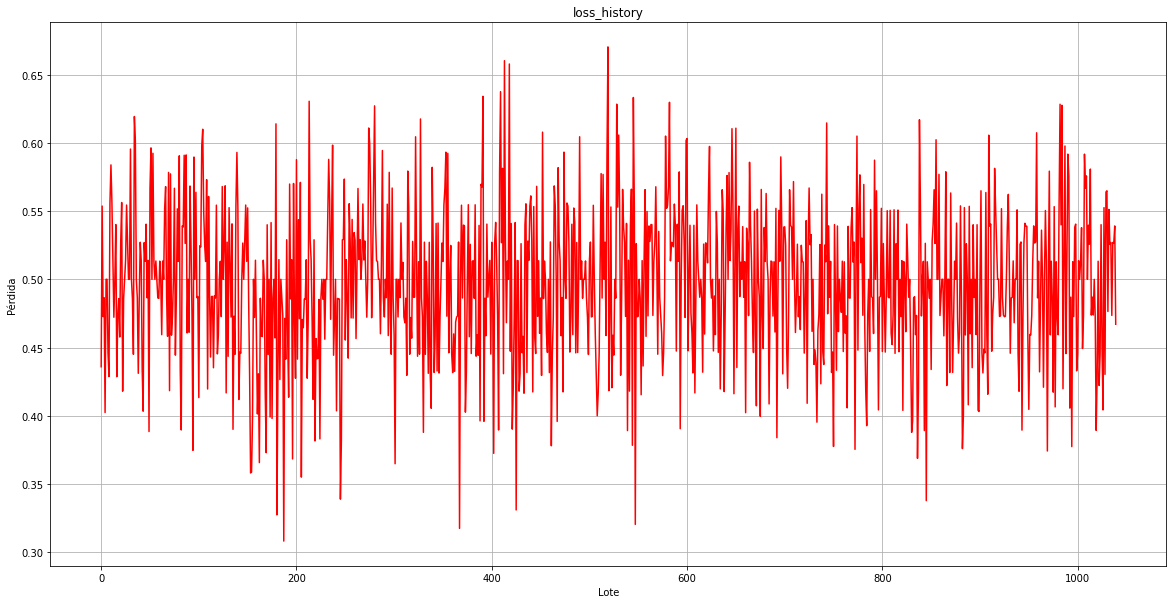

In [14]:
fig = plt.figure(figsize = (20, 10))
plt.plot(range(0,len(loss_history)), loss_history, 'r')
plt.title('loss_history')
plt.xlabel('Lote')
plt.ylabel('Pérdida')
plt.grid()
plt.show()

In [15]:
print("[time] Total training time: {:.3f}s".format(train_end-train_start)) # DEBUG
print(f"[time] Time for each epoch:")
for i,x in enumerate(epoch_timing):
    print ("\t{:<5} {:.3f}s".format(i+1, x))

[time] Total training time: 5043.945s
[time] Time for each epoch:
	1     302.039s
	2     286.380s
	3     277.030s
	4     271.465s
	5     267.626s
	6     262.004s
	7     255.696s
	8     251.575s
	9     252.005s
	10    250.026s
	11    246.923s
	12    243.750s
	13    239.322s
	14    238.930s
	15    236.261s
	16    233.888s
	17    236.749s
	18    232.180s
	19    228.404s
	20    231.688s


# DEBUG

Esta celda y las siguientes son para testear. Han de ser eliminadas cuando se limpie el código de este *notebook*.

In [16]:
#f = birds_df.iloc[5][file_col_name]
#librosa_process(birds_path+f, True)

In [17]:
random.uniform(1,1)

1.0

In [18]:
print(*range(0,10))
print(*range(1,10))

0 1 2 3 4 5 6 7 8 9
1 2 3 4 5 6 7 8 9
